## Introduction

AirSeaFluxCode is developed to provide an easy and accessible way to calculate turbulent surface fluxes (TSFs) from a small number of bulk variables and for a viariety of bulk algorithms. 

By running AirSeaFluxCode you can compare different bulk algorithms and to also investigate the effect choices within the implementation of each parameterisation have on the TSFs estimates. 


### Getting started

Let's first import the basic python packages we will need for reading in our input data, to perform basic statistics  and plotting

In [29]:
# first import all packages you might need
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from tabulate import tabulate

from AirSeaFluxCode import AirSeaFluxCode

### AirSeaFluxCode examples

AirSeaFluxCode is set up to run in its default setting with a minimum number of input variables, namely wind speed; air temperature; and sea surface temperature. Let's load the code, import some real data composed for testing it (Research vessel data) and run AirSeaFluxCode with default settings (output height 10m, cool skin/warm layer corrections turned off, bulk algorithm Smith 1988, gustiness on, saturation vapour pressure following Buck (2012), tolerance limits set for both flux estimates and height adjusted variables (['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1]), number of iterations are ten, non converged points are set to missing and Monin-Obukhov stability length is calculated following the ECMWF implementation.

In [30]:
sbk = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_quicche.nc')

## Sailbuoy
jd    = sbk['doy'].interpolate_na('time').data
u     = sbk['wind_speed'].interpolate_na('time').data
zu    = 1
t     = sbk['air_temp'].interpolate_na('time').data
zt    = 1
rh    = np.ones(len(jd))*np.nan # sbk['rh'].interpolate_na('time').data
zq    = 1
P     = np.ones(len(jd))*1013
ts    = sbk['sst'].interpolate_na('time').values
sw_dn = np.zeros(len(jd))
lw_dn = np.zeros(len(jd))
lat   = sbk['latitude'].interpolate_na('time').data
lon   = sbk['longitude'].interpolate_na('time').data
zi    = 600
rain  = 0 
zts   = -1
Ss   = sbk['sss'].interpolate_na('time').data

date = np.asarray(sbk["doy"])
lon = np.asarray(sbk["longitude"])
lat = np.asarray(sbk["latitude"])
spd = np.asarray(sbk["wind_speed"])
t = np.asarray(sbk["air_temp"])
sst = np.asarray(sbk["sst"])
rh = np.asarray(np.ones(len(jd))*80)
p = np.asarray(np.ones(len(jd))*1013)
sw = np.asarray(np.zeros(len(jd)))
hu = np.asarray(1)
ht = np.asarray(1)
hin = np.array([hu, ht, ht])
del hu, ht

outvar = ("tau", "sensible", "latent", "u10n", "t10n", "q10n")
# run AirSeaFluxCode
res = AirSeaFluxCode(spd, t, sst, "skin", meth="C35", lat=lat, hin=hin, hum=["rh", rh], P=p, cskin=0, Rs=sw,
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], L="tsrv", out_var = outvar)
flg = res["flag"]

res is the output of AirSeaFluxCode which is a dataFrame with keys: "tau", "sensible", "latent", "u10n", "t10n", "q10n". Let's plot the flux estimates.

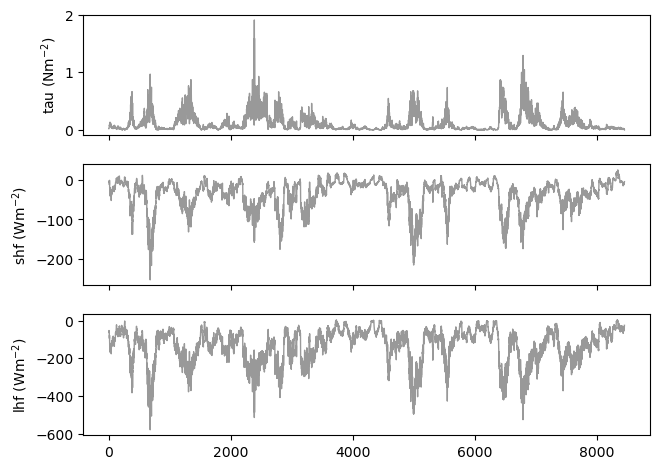

In [31]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["sensible"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["latent"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()

In [39]:
res['t10n'][flg == 'l']

4314    293.827207
4315    294.408803
4316    294.102920
4317    294.384323
4468    294.719653
4469    294.694812
4470    294.895138
6203    294.434468
6206    294.363255
6351    293.495319
6352    294.257754
6358    293.439112
Name: t10n, dtype: float64

<Axes: >

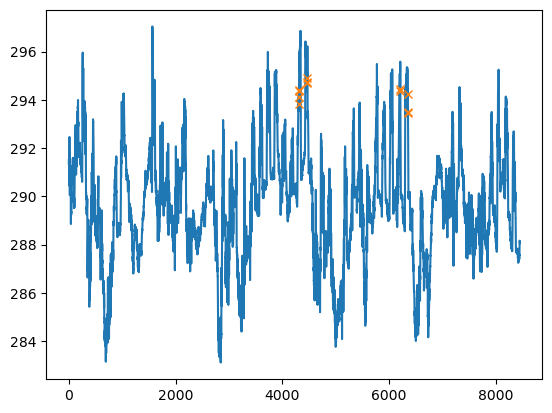

In [41]:
res['t10n'].plot()
res['t10n'][flg == 'l'].plot(marker='x',lw=0)


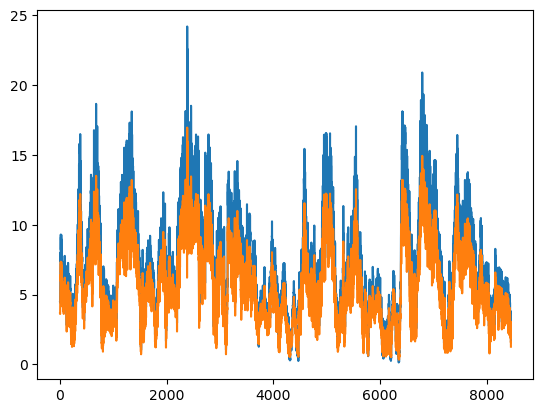

In [33]:
res['u10n'].plot()
plt.plot((sbk["wind_speed"]).values)

<Axes: >

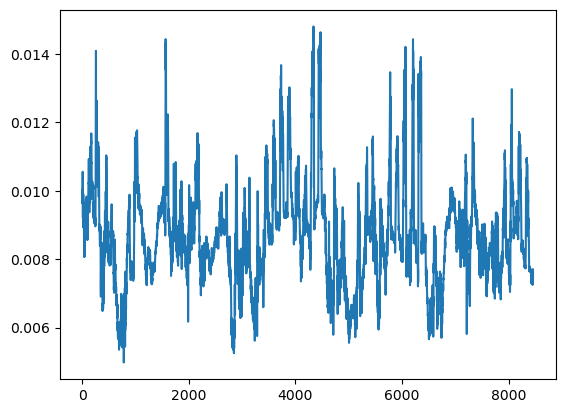

In [35]:
res['q10n'].plot()

You can save the output in a csv file

In [ ]:
res.to_csv("test_AirSeaFluxCode.csv")

and generate some statistics which you can save in a txt file

In [14]:
print("Input summary", file=open('./stats.txt', 'a'))
print('input file name: {}, \n method: {}, \n gustiness: {}, \n cskin: {},'
      ' \n tolerance: {}, \n qmethod: {}, \n L: {}'.format("data_all.csv", "UA", "on",
                                                           0, "all", "Buck2", "Rb"),
      file=open('./stats.txt', 'a'))
ttl = np.asarray(["tau  ", "shf  ", "lhf  ", "u10n ", "t10n ", "q10n "])
header = ["var", "mean", "median", "min", "max", "5%", "95%"]
n = np.shape(res)
stats = np.copy(ttl)
a = res.iloc[:,:-1].to_numpy(dtype="float64").T
stats = np.c_[stats, np.nanmean(a, axis=1)]
stats = np.c_[stats, np.nanmedian(a, axis=1)]
stats = np.c_[stats, np.nanmin(a, axis=1)]
stats = np.c_[stats, np.nanmax(a, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 5, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 95, axis=1)]
print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
               floatfmt=("s", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e")),
      file=open('./stats.txt', 'a'))
print('-'*79+'\n', file=open('./stats.txt', 'a'))
del a

In [14]:
pip install AirSeaFluxCode

ERROR: Could not find a version that satisfies the requirement AirSeaFluxCode (from versions: none)
ERROR: No matching distribution found for AirSeaFluxCode
Note: you may need to restart the kernel to use updated packages.


In [28]:
np.arange(sbk.time.values[0].astype('datetime64[m]'),sbk.time.values[-1].astype('datetime64[m]')+np.timedelta64(1,'m'),np.timedelta64(10,'m'))

array(['2023-03-06T11:20', '2023-03-06T11:30', '2023-03-06T11:40', ...,
       '2023-05-04T04:20', '2023-05-04T04:30', '2023-05-04T04:40'],
      dtype='datetime64[m]')

In [27]:
sbk.time.values[-1].astype('datetime64[m]')

numpy.datetime64('2023-05-04T04:40')

In [25]:
sbk.time.values[0].astype('datetime64[m]')

numpy.datetime64('2023-03-06T11:20')